In [1]:
import os
import json
import copy
import numpy as np

import librosa
from IPython.display import Audio

import tsaug
from tsaug.visualization import plot

In [2]:
dir_data_root = os.path.join('..', 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_aug = os.path.join(dir_data_root, 'json', 'patients_augmented')

# Test

## Load

In [9]:
patient_id = '1'
session_id = '76'
exercise_id = '02'
poi_id = 'LefteyeMidbottom'
coordinate = 'xs'

In [10]:
file_exercise = '%s_%s_%s.json' % (patient_id, session_id, exercise_id)
path_exercise = os.path.join(dir_exercises, file_exercise)
datum = json.load(open(path_exercise, 'r'))

d = np.array([datum['pois'][poi_id]['xs'],datum['pois'][poi_id]['ys'], datum['pois'][poi_id]['zs']])

In [11]:
d.shape

(3, 282)

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

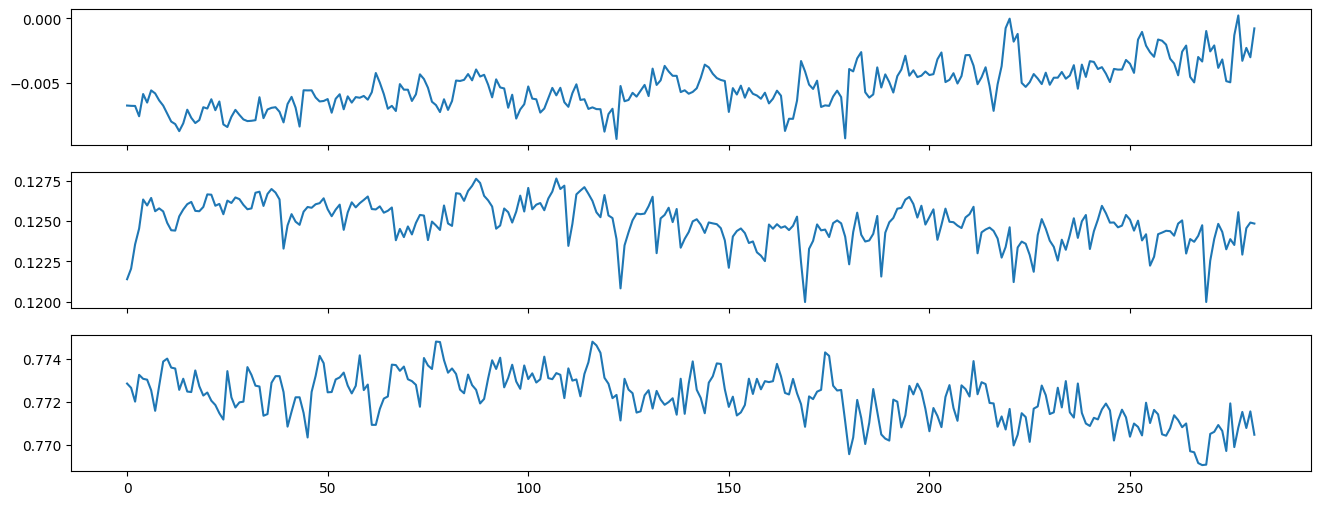

In [12]:
plot(d)

## Add noise

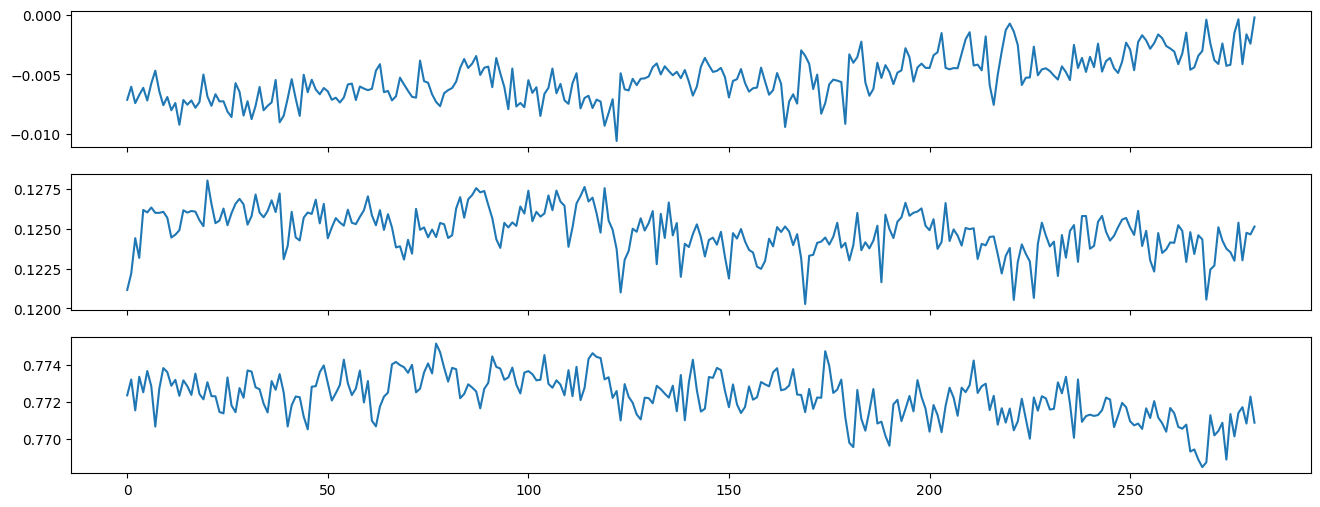

In [13]:
d_aug = tsaug.AddNoise(scale=0.07).augment(d)

plot(d_aug);

## Drift 

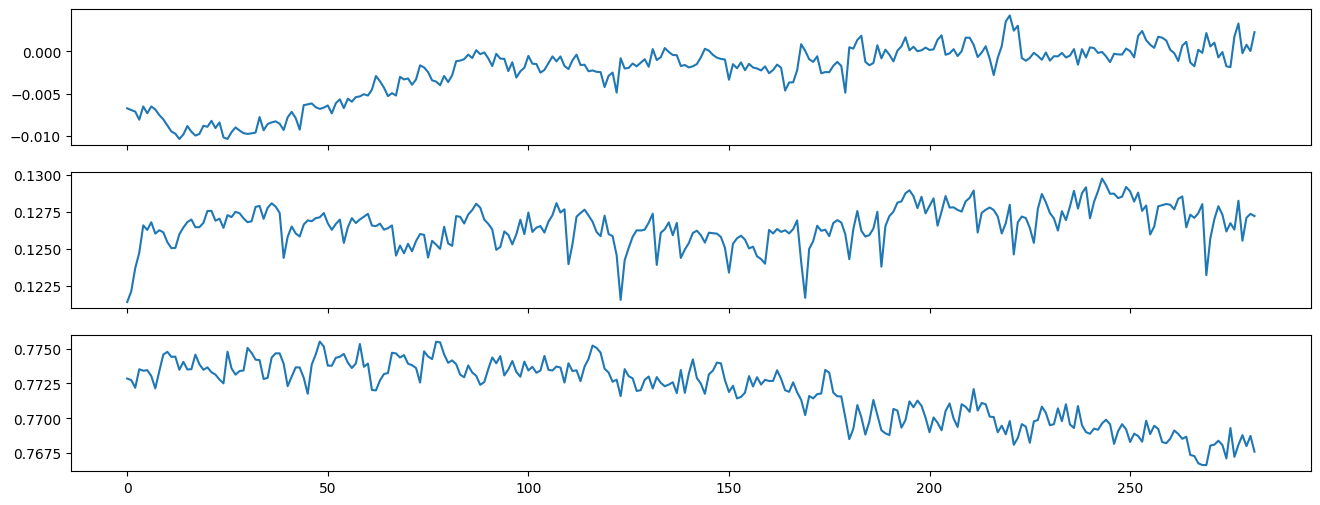

In [14]:
d_aug = tsaug.Drift(max_drift=0.5, n_drift_points=5).augment(d)

plot(d_aug);

## Quantize

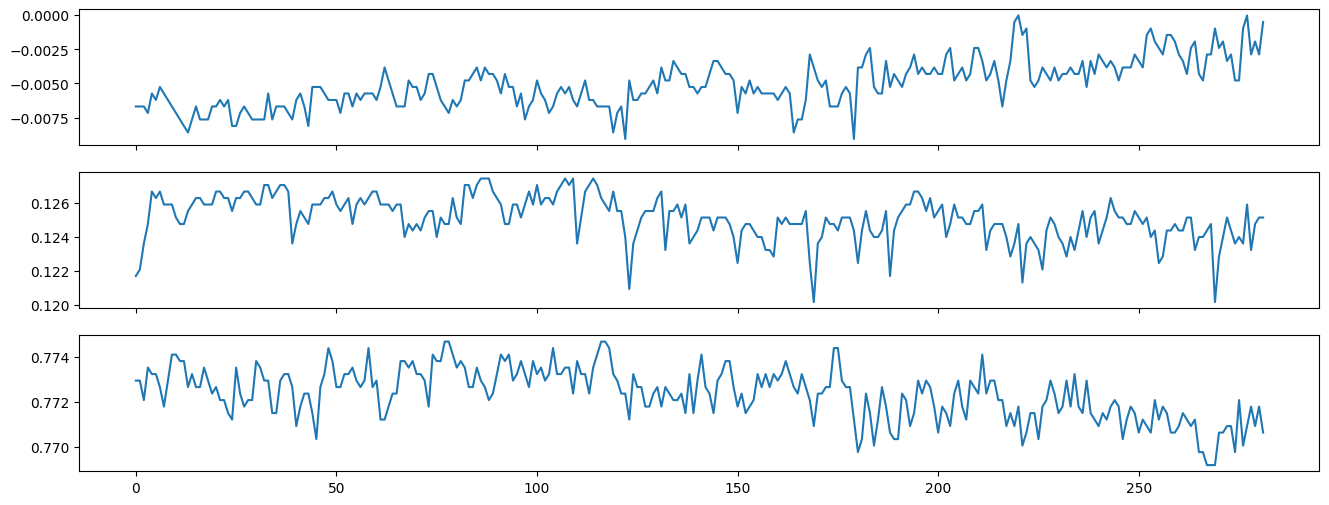

In [15]:
d_aug = tsaug.Quantize(n_levels=20).augment(d)

plot(d_aug);

## Pool

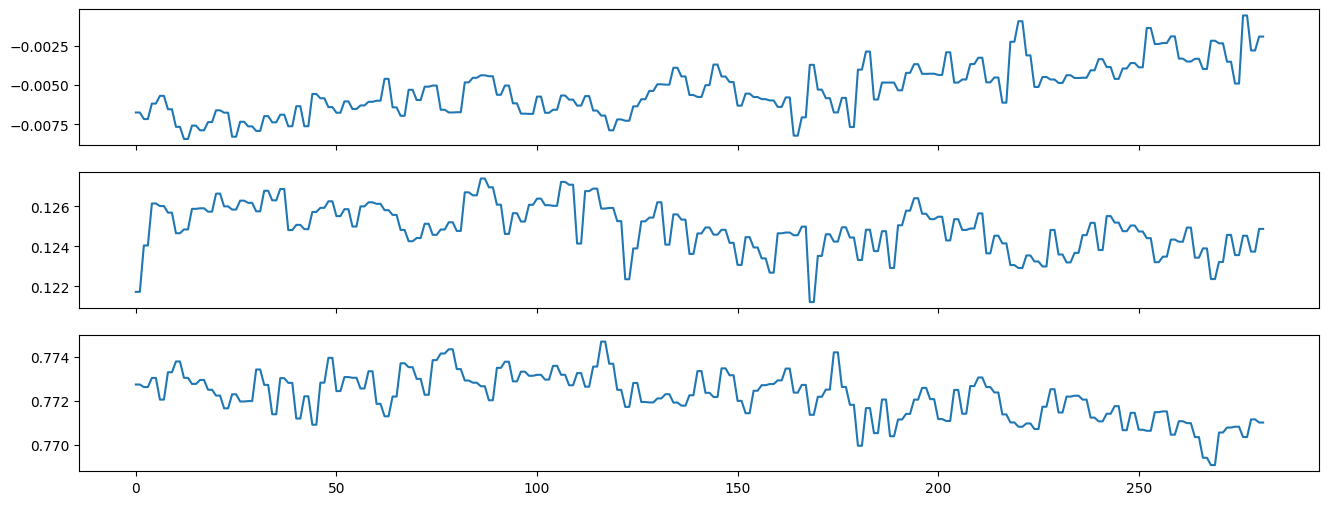

In [16]:
d_aug = tsaug.Pool(size=2).augment(d)

plot(d_aug);

# Augument

In [17]:
if not os.path.exists(dir_exercises_aug):
    os.makedirs(dir_exercises_aug)

In [18]:
def addNoise (x):
    return tsaug.AddNoise(scale=0.01).augment(x)
def drift (x):
    return tsaug.Drift(max_drift=0.5, n_drift_points=5).augment(x)
def quantize (x):
    return tsaug.Quantize(n_levels=20).augment(x)
def pool (x):
    return tsaug.Pool(size=2).augment(x)

In [19]:
transformations_names = [
    'AddNoise',
    'Drift',
    'Quantize',
    'Pool'
]

In [20]:
transformations_fns = [
    addNoise,
    drift,
    quantize,
    pool
]

In [21]:
def apply_transformation(x, transformation_id):
    x['meta']['transformation_id'] = transformation_id
    x['meta']['transformation'] = transformations_names[transformation_id]
    transformation_fn = transformations_fns[transformation_id]
    
    for poi_tag in x['pois'].keys():
        poi = x['pois'][poi_tag]
        pois_series = np.array([
            poi['xs'],
            poi['ys'], 
            poi['zs']])
        
        aug_series = transformation_fn(pois_series)
        x['pois'][poi_tag]['xs'] = aug_series[0].tolist()
        x['pois'][poi_tag]['ys'] = aug_series[1].tolist()
        x['pois'][poi_tag]['s'] = aug_series[2].tolist()
        
        
    return x

In [22]:
for file in os.listdir(dir_exercises):
    if file == '.DS_Store': continue
        
    path = os.path.join(dir_exercises, file)
    
    datum = json.load(open(path))
    patient_id, session_id, exercise_id = file.split('.')[0].split('_')

    for transformation_id, __name in enumerate(transformations_names):    
        datum_aug = apply_transformation(copy.deepcopy(datum), transformation_id)
        new_file = '%s_%s_%s_%s.json' % (patient_id, session_id, exercise_id, transformation_id)
        new_path = os.path.join(dir_exercises_aug, new_file)
        with open(new_path,'w') as f_w:
            json.dump(datum_aug, f_w) 